# Intro to Neural Networks and Tensorflow

For this notebook, **you need the Tensorflow, Numpy and Matplotlib libraries**. 

* One simple way to get Numpy and Matplotib is to get install Anaconda: https://docs.anaconda.com/free/anaconda/install/index.html
* Tensorflow can be installed from here: https://www.tensorflow.org/install

If you plan to do anything even moderately complex, try to get it installed with gpu support.

Here we import some useful libaries and functions.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

# For reproducible results:
np.random.seed(42)

Here we create a dense, fully connected neural network. The input is 1D and the output 1D.

First, we start with input layer. Then we make three hidden layers and then the output layer. Finally, we make the model. 

In [2]:
# Create input layer
input_layer = Input(shape = (1,))

# Hidden layer with 32 neurons and ReLu as activation, 
# take in input
x = Dense(32, activation = 'relu')(input_layer)

# Second hidden layer, takes in first hidden layer
x = Dense(32, activation = 'relu')(x)

# Third hidden layer
x = Dense(32, activation = 'relu')(x)

# Create final layer which is just an affine tranformation
# Note: for activation there is None
output = Dense(1, activation = None)(x)

# Now create the model
model = tf.keras.Model(inputs = input_layer, outputs = output)

# Second model
model2 = tf.keras.Model(inputs = input_layer, outputs = output)

Here is a depiction of the neural network (though, fewer than 32 neurons in the hidden layers to make it look neater).
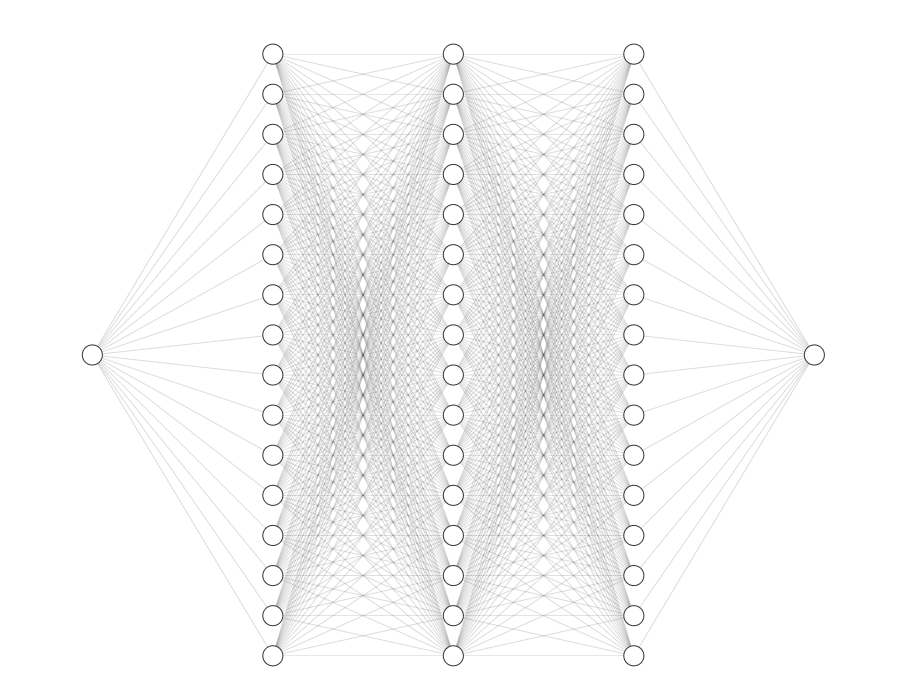(attachment:image.png)



Aletnatively, a more mathematical representation: 

$$x_1 = \sigma \circ A_1(x_0) $$
$$x_2 = \sigma \circ A_2 (x_1)$$
$$x_3 = \sigma \circ A_3(x_2) $$
$$x_4 = A_4(x_3) $$

where $A_i$ is an affine transformation  and $\sigma$ is element-wise ReLU and $A_4$.

### Exercise.

Create the above neural network using the sequential feature. Sequential is slightly easier to use, but is less flexible.

## Fit Model to Data

We create fake data, with Gaussian noise.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Noise factor
noise = 1

n_data = 1000

# Evenly space vector from 0 to 1
X = np.linspace(0,10, n_data)

# Y is a complicated function of X plus some Gaussian noise
Y = 2*np.cos(0.5*X**2) + 4*np.sin(0.5*X) + 2*np.sin(0.05*X) +  noise*np.random.normal(0, 1, n_data)

To train, we'll use a loss funciton of mean squared error and as an optimizer, Adam. 

An epoch is a passes do through the entire training data. The batch size is how many samples of the data we use to determine how to change the parameters with gradient descent.

In [4]:
# Optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

# Compile model
model.compile(optimizer = adam_optimizer, loss = 'mean_squared_error')

# Fit the model to the data
history = model.fit(X, Y,
        epochs = 512,    # This is how many times it runs through the data
        batch_size = 64, # This is how many data samples taken during the parameter update
        shuffle = True)

model.summary()

Epoch 1/512
16/16 [==============================] - 1s 1ms/step - loss: 11.1746
Epoch 2/512
16/16 [==============================] - 0s 1ms/step - loss: 10.7524
Epoch 3/512
16/16 [==============================] - 0s 1ms/step - loss: 10.3791
Epoch 4/512
16/16 [==============================] - 0s 1ms/step - loss: 9.6715
Epoch 5/512
16/16 [==============================] - 0s 2ms/step - loss: 8.8417
Epoch 6/512
16/16 [==============================] - 0s 2ms/step - loss: 7.7817
Epoch 7/512
16/16 [==============================] - 0s 1ms/step - loss: 6.5372
Epoch 8/512
16/16 [==============================] - 0s 1ms/step - loss: 5.3116
Epoch 9/512
16/16 [==============================] - 0s 1ms/step - loss: 4.1917
Epoch 10/512
16/16 [==============================] - 0s 1ms/step - loss: 3.5210
Epoch 11/512
16/16 [==============================] - 0s 2ms/step - loss: 3.2605
Epoch 12/512
16/16 [==============================] - 0s 2ms/step - loss: 3.1873
Epoch 13/512
16/16 [==============

Let's see how the loss decreased with time.

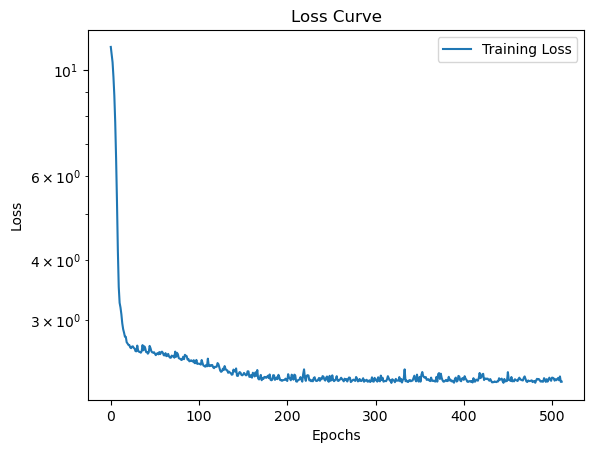

In [5]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss Curve')
plt.legend()
plt.show()

Now, how well the neural network is approximating the data.

Text(0.5, 1.0, 'Neural Network Fit')

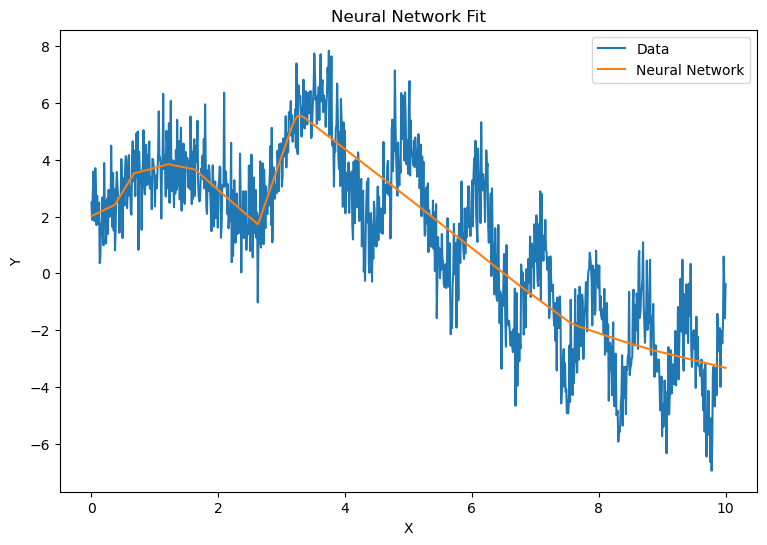

In [6]:
plt.figure(figsize=(9,6))
plt.plot(X,Y, label = 'Data')
plt.plot(X, model(X), label = 'Neural Network')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Neural Network Fit')

We'll see that we can improve that with how we train. First, create a new model.

In [7]:
# Create input layer
input_layer = Input(shape = (1,))

# Hidden layer with 32 neurons and ReLu as activation, 
# take in input
x = Dense(32, activation = 'relu')(input_layer)

# Second hidden layer, takes in first hidden layer
x = Dense(32, activation = 'relu')(x)

# Third hidden layer
x = Dense(32, activation = 'relu')(x)

# Create final layer which is just linear
output = Dense(1, activation = None)(x)

# Now create the model
model2 = tf.keras.Model(inputs = input_layer, outputs = output)

Now, instead of a constant batch size, we'll going to start 1, then double every 128 epochs until we get to 8. The final number of epochs will be the same as before.

The logic behind this is that at the beginning we want a lot of randomness, to explore parameter space and avoid getting stationary points. Using just 1 data point to estimate loss function, we should expect lots of rnadomness. However, as we go forth we want to focus on finding a good solution, hence "turn down" the randomness. Increasing the batch size, that is, increasing hte number of data points being used to estimate the loss, decreases randomness.

Notice that each epoch takes longer for batch size of 1 compared to 64. It's quicker in batches of 64. That's the price we pay.

In [8]:
# Compile the mode

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

model2.compile(optimizer = optimizer, loss = 'mean_squared_error')

history_array = []

batch_num = 1

for run in range(4):
    print(f'\n Commencing with batch size: {batch_num} \n')
    
    # Do fit
    history2 = model2.fit(X, Y,
        epochs = 128,   
        batch_size = batch_num,
        shuffle = True)
    
    # Quadruple batch_num
    batch_num *= 2
    
    #Add to history_array
    history_array += history2.history['loss']



 Commencing with batch size: 1 

Epoch 1/128
1000/1000 [==============================] - 5s 4ms/step - loss: 6.1187
Epoch 2/128
1000/1000 [==============================] - 2s 2ms/step - loss: 3.0304
Epoch 3/128
1000/1000 [==============================] - 2s 2ms/step - loss: 2.9721
Epoch 4/128
1000/1000 [==============================] - 2s 2ms/step - loss: 2.8540
Epoch 5/128
1000/1000 [==============================] - 2s 2ms/step - loss: 2.8259
Epoch 6/128
1000/1000 [==============================] - 3s 3ms/step - loss: 2.8160
Epoch 7/128
1000/1000 [==============================] - 2s 2ms/step - loss: 2.7758
Epoch 8/128
1000/1000 [==============================] - 2s 2ms/step - loss: 2.7954
Epoch 9/128
1000/1000 [==============================] - 2s 2ms/step - loss: 2.7313
Epoch 10/128
1000/1000 [==============================] - 3s 3ms/step - loss: 2.7018
Epoch 11/128
1000/1000 [==============================] - 3s 3ms/step - loss: 2.7082
Epoch 12/128
1000/1000 [================

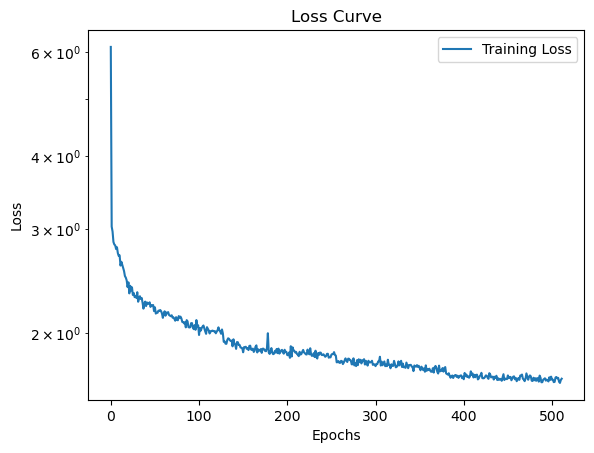

In [9]:
plt.plot(history_array, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss Curve')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Neural Network Fit')

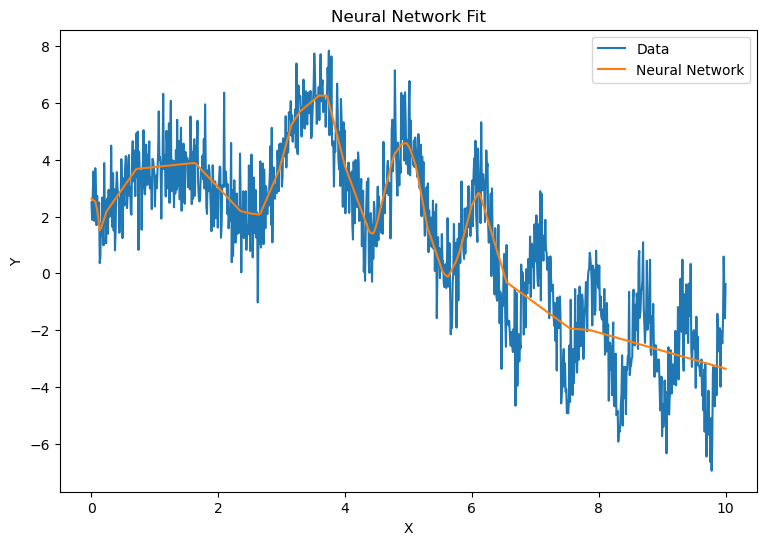

In [10]:
plt.figure(figsize=(9,6))
plt.plot(X,Y, label = 'Data')
plt.plot(X, model2(X), label = 'Neural Network')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Neural Network Fit')